# Host-Pathogen simulation

## The following cell is setting up GUI for an interactive simulation

In [ ]:
## "pycxsimulator.py"
## Dynamic, interactive simulation GUI for PyCX
##
## Project website:
## https://github.com/hsayama/PyCX
##
## Initial development by:
## Chun Wong
## email@chunwong.net
##
## Revisions by:
## Hiroki Sayama
## sayama@binghamton.edu
##
## Copyright 2012 Chun Wong
## Copyright 2012-2019 Hiroki Sayama
##
## Simulation control & GUI extensions
## Copyright 2013 Przemyslaw Szufel & Bogumil Kaminski
## {pszufe, bkamins}@sgh.waw.pl
##
## Fixing errors due to "the grid and pack problem" by:
## Toshihiro Tanizawa
## tanizawa@ee.kochi-ct.ac.jp
## began at 2016-06-15(Wed) 17:10:17
## fixed grid() and pack() problem on 2016-06-21(Tue) 18:29:40
##

import matplotlib
matplotlib.use('TkAgg')

import pylab

## version check added by Hiroki Sayama on 01/08/2019
import sys
if sys.version_info[0] == 3: # Python 3
    from tkinter import *
    from tkinter.ttk import Notebook
else:                        # Python 2
    from Tkinter import *
    from ttk import Notebook


class GUI:

    # Constructor
    def __init__(self, title='PyCX Simulator', interval=0, stepSize=1, parameterSetters=[]):

        ## all GUI variables moved to inside constructor by Hiroki Sayama 10/09/2018

        self.titleText = title
        self.timeInterval = interval
        self.stepSize = stepSize
        self.parameterSetters = parameterSetters
        self.varEntries = {}
        self.statusStr = ""

        self.running = False
        self.modelFigure = None
        self.currentStep = 0

        # initGUI() removed by Hiroki Sayama 10/09/2018
        
        #create root window
        self.rootWindow = Tk()
        self.statusText = StringVar(self.rootWindow, value=self.statusStr) # at this point, statusStr = ""
        # added "self.rootWindow" above by Hiroki Sayama 10/09/2018
        self.setStatusStr("Simulation not yet started")

        self.rootWindow.wm_title(self.titleText) # titleText = 'PyCX Simulator'
        self.rootWindow.protocol('WM_DELETE_WINDOW', self.quitGUI)
        self.rootWindow.geometry('450x300')
        self.rootWindow.columnconfigure(0, weight=1)
        self.rootWindow.rowconfigure(0, weight=1)
        
        self.notebook = Notebook(self.rootWindow)      
        # self.notebook.grid(row=0,column=0,padx=2,pady=2,sticky='nswe') # commented out by toshi on 2016-06-21(Tue) 18:30:25
        self.notebook.pack(side=TOP, padx=2, pady=2)
        
        # added "self.rootWindow" by Hiroki Sayama 10/09/2018
        self.frameRun = Frame(self.rootWindow)
        self.frameSettings = Frame(self.rootWindow)
        self.frameParameters = Frame(self.rootWindow)
        self.frameInformation = Frame(self.rootWindow)
        
        self.notebook.add(self.frameRun,text="Run")
        self.notebook.add(self.frameSettings,text="Settings")
        self.notebook.add(self.frameParameters,text="Parameters")
        self.notebook.add(self.frameInformation,text="Info")
        self.notebook.pack(expand=NO, fill=BOTH, padx=5, pady=5 ,side=TOP)
        # self.notebook.grid(row=0, column=0, padx=5, pady=5, sticky='nswe')   # commented out by toshi on 2016-06-21(Tue) 18:31:02
        
        self.status = Label(self.rootWindow, width=40,height=3, relief=SUNKEN, bd=1, textvariable=self.statusText)
        # self.status.grid(row=1,column=0,padx=5,pady=5,sticky='nswe') # commented out by toshi on 2016-06-21(Tue) 18:31:17
        self.status.pack(side=TOP, fill=X, padx=5, pady=5, expand=NO)

        # -----------------------------------
        # frameRun
        # -----------------------------------
        # buttonRun
        self.runPauseString = StringVar(self.rootWindow) # added "self.rootWindow" by Hiroki Sayama 10/09/2018
        self.runPauseString.set("Run")
        self.buttonRun = Button(self.frameRun,width=30,height=2,textvariable=self.runPauseString,command=self.runEvent)
        self.buttonRun.pack(side=TOP, padx=5, pady=5)
        self.showHelp(self.buttonRun,"Runs the simulation (or pauses the running simulation)")
        
        # buttonStep
        self.buttonStep = Button(self.frameRun,width=30,height=2,text='Step Once',command=self.stepOnce)
        self.buttonStep.pack(side=TOP, padx=5, pady=5)
        self.showHelp(self.buttonStep,"Steps the simulation only once")
        
        # buttonReset
        self.buttonReset = Button(self.frameRun,width=30,height=2,text='Reset',command=self.resetModel)
        self.buttonReset.pack(side=TOP, padx=5, pady=5) 
        self.showHelp(self.buttonReset,"Resets the simulation")

        # -----------------------------------
        # frameSettings
        # -----------------------------------
        can = Canvas(self.frameSettings)
        
        lab = Label(can, width=25,height=1,text="Step size ", justify=LEFT, anchor=W,takefocus=0)
        lab.pack(side='left')
        
        self.stepScale = Scale(can,from_=1, to=50, resolution=1,command=self.changeStepSize,orient=HORIZONTAL, width=25,length=150)
        self.stepScale.set(self.stepSize)
        self.showHelp(self.stepScale,"Skips model redraw during every [n] simulation steps\nResults in a faster model run.")
        self.stepScale.pack(side='left')
        
        can.pack(side='top')
    
        can = Canvas(self.frameSettings)
        lab = Label(can, width=25,height=1,text="Step visualization delay in ms ", justify=LEFT, anchor=W,takefocus=0)
        lab.pack(side='left')
        self.stepDelay = Scale(can,from_=0, to=max(2000,self.timeInterval),
                               resolution=10,command=self.changeStepDelay,orient=HORIZONTAL, width=25,length=150)
        self.stepDelay.set(self.timeInterval)
        self.showHelp(self.stepDelay,"The visualization of each step is delays by the given number of milliseconds.")
        self.stepDelay.pack(side='left')
        
        can.pack(side='top')
        
        # --------------------------------------------
        # frameInformation
        # --------------------------------------------
        scrollInfo = Scrollbar(self.frameInformation)
        self.textInformation = Text(self.frameInformation, width=45,height=13,bg='lightgray',wrap=WORD,font=("Courier",10))
        scrollInfo.pack(side=RIGHT, fill=Y)
        self.textInformation.pack(side=LEFT,fill=BOTH,expand=YES)
        scrollInfo.config(command=self.textInformation.yview)
        self.textInformation.config(yscrollcommand=scrollInfo.set)
        
        # --------------------------------------------
        # ParameterSetters
        # --------------------------------------------
        for variableSetter in self.parameterSetters:
            can = Canvas(self.frameParameters)
            
            lab = Label(can, width=25,height=1,text=variableSetter.__name__+" ",anchor=W,takefocus=0)
            lab.pack(side='left')
            
            ent = Entry(can, width=11)
            ent.insert(0, str(variableSetter()))
            
            if variableSetter.__doc__ != None and len(variableSetter.__doc__) > 0:
                self.showHelp(ent,variableSetter.__doc__.strip())
                
            ent.pack(side='left')
                
            can.pack(side='top')
            
            self.varEntries[variableSetter]=ent
            
        if len(self.parameterSetters) > 0:
            self.buttonSaveParameters = Button(self.frameParameters,width=50,height=1,
                                               command=self.saveParametersCmd,text="Save parameters to the running model",state=DISABLED)
            self.showHelp(self.buttonSaveParameters,
                          "Saves the parameter values.\nNot all values may take effect on a running model\nA model reset might be required.")
            self.buttonSaveParameters.pack(side='top',padx=5,pady=5)
            self.buttonSaveParametersAndReset = Button(self.frameParameters,width=50,height=1,
                                                       command=self.saveParametersAndResetCmd,text="Save parameters to the model and reset the model")
            self.showHelp(self.buttonSaveParametersAndReset,"Saves the given parameter values and resets the model")
            self.buttonSaveParametersAndReset.pack(side='top',padx=5,pady=5)
            
    # <<<<< Init >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    
    def setStatusStr(self,newStatus):
        self.statusStr = newStatus
        self.statusText.set(self.statusStr)        
        
    # model control functions for changing parameters
    def changeStepSize(self,val):        
        self.stepSize = int(val)
        
    def changeStepDelay(self,val):        
        self.timeInterval= int(val)
        
    def saveParametersCmd(self):
        for variableSetter in self.parameterSetters:
            variableSetter(float(self.varEntries[variableSetter].get()))
            self.setStatusStr("New parameter values have been set")
            
    def saveParametersAndResetCmd(self):
        self.saveParametersCmd()
        self.resetModel()

    # <<<< runEvent >>>>>
    # This event is envoked when "Run" button is clicked.
    def runEvent(self):
        self.running = not self.running
        if self.running:
            self.rootWindow.after(self.timeInterval,self.stepModel)
            self.runPauseString.set("Pause")
            self.buttonStep.configure(state=DISABLED)
            self.buttonReset.configure(state=DISABLED)
            if len(self.parameterSetters) > 0:
                self.buttonSaveParameters.configure(state=NORMAL)
                self.buttonSaveParametersAndReset.configure(state=DISABLED)     
        else:
            self.runPauseString.set("Continue Run")
            self.buttonStep.configure(state=NORMAL)
            self.buttonReset.configure(state=NORMAL)
            if len(self.parameterSetters) > 0:
                self.buttonSaveParameters.configure(state=NORMAL)
                self.buttonSaveParametersAndReset.configure(state=NORMAL)

    def stepModel(self):
        if self.running:
            self.modelStepFunc()
            self.currentStep += 1
            self.setStatusStr("Step "+str(self.currentStep))
            self.status.configure(foreground='black')
            if (self.currentStep) % self.stepSize == 0:
                self.drawModel()
            self.rootWindow.after(int(self.timeInterval*1.0/self.stepSize),self.stepModel)

    def stepOnce(self):
        self.running = False
        self.runPauseString.set("Continue Run")
        self.modelStepFunc()
        self.currentStep += 1
        self.setStatusStr("Step "+str(self.currentStep))
        self.drawModel()
        if len(self.parameterSetters) > 0:
            self.buttonSaveParameters.configure(state=NORMAL)

    def resetModel(self):
        self.running = False        
        self.runPauseString.set("Run")
        self.modelInitFunc()
        self.currentStep = 0;
        self.setStatusStr("Model has been reset")
        self.drawModel()

    def drawModel(self):
        pylab.ion() # bug fix by Alex Hill in 2013
        if self.modelFigure == None or self.modelFigure.canvas.manager.window == None:
            self.modelFigure = pylab.figure()
        self.modelDrawFunc()
        self.modelFigure.canvas.manager.window.update()
        pylab.show() # bug fix by Hiroki Sayama in 2016

    def start(self,func=[]):
        if len(func)==3:
            self.modelInitFunc = func[0]
            self.modelDrawFunc = func[1]
            self.modelStepFunc = func[2]            
            if (self.modelStepFunc.__doc__ != None and len(self.modelStepFunc.__doc__)>0):
                self.showHelp(self.buttonStep,self.modelStepFunc.__doc__.strip())                
            if (self.modelInitFunc.__doc__ != None and len(self.modelInitFunc.__doc__)>0):
                self.textInformation.config(state=NORMAL)
                self.textInformation.delete(1.0, END)
                self.textInformation.insert(END, self.modelInitFunc.__doc__.strip())
                self.textInformation.config(state=DISABLED)
                
            self.modelInitFunc()
            self.drawModel()     
        self.rootWindow.mainloop()

    def quitGUI(self):
        pylab.close('all')
        self.rootWindow.quit()
        self.rootWindow.destroy()
    
    def showHelp(self, widget,text):
        def setText(self):
            self.statusText.set(text)
            self.status.configure(foreground='blue')
            
        def showHelpLeave(self):
            self.statusText.set(self.statusStr)
            self.status.configure(foreground='black')
        widget.bind("<Enter>", lambda e : setText(self))
        widget.bind("<Leave>", lambda e : showHelpLeave(self))

## The host pathogen model
Upon running the 74th line (GUI package), two screens would pop up. The first has the layout of the initial configuration, the second window has the control for running the simulation (start, pause, tweaking the parameters)

In [103]:
# Simple CA simulator in Python
#
# *** Hosts & Pathogens ***
#
# Copyright 2008-2012 Hiroki Sayama
# sayama@binghamton.edu

# Modified to run with Python 3

import matplotlib.pyplot as plt
#matplotlib.use('TkAgg')
import numpy as np
import pylab as PL
import random as RD
import scipy as SP

RD.seed()

width = 50
height = 50
initProb = 0.01
infectionRate = 0.85
regrowthRate = 0.15

def init():
    global time, config, nextConfig, density
    density = []
    time = 0
    config = SP.zeros([height, width])
    for x in range(width):
        for y in range(height):
            if RD.random() < initProb:
                state = 2
            else:
                state = 1
            config[y, x] = state

    nextConfig = SP.zeros([height, width])

def draw():
    PL.cla()
    PL.pcolor(config, vmin = 0, vmax = 2, cmap = PL.cm.jet)
    PL.axis('image')
    PL.title('t = ' + str(time))
    PL.show()
    
def plot_proportion():
    PL.figure(figsize=(15, 6))
    PL.plot(density)
    PL.title("The proportion of healthy and infected hosts")
    PL.xlabel("Time steps")
    PL.show()

def step():
    global time, config, nextConfig, density
    time += 1
    for x in range(width):
        for y in range(height):
            state = config[y, x]
            if state == 0:
                for dx in range(-1, 2):
                    for dy in range(-1, 2):
                        if config[(y+dy)%height, (x+dx)%width] == 1:
                            if RD.random() < regrowthRate:
                                state = 1
            elif state == 1:
                for dx in range(-1, 2):
                    for dy in range(-1, 2):
                        if config[(y+dy)%height, (x+dx)%width] == 2:
                            if RD.random() < infectionRate:
                                state = 2
            else:
                state = 0
            nextConfig[y, x] = state
    density.append(np.count_nonzero(config == 1) / (np.count_nonzero(config == 2)\
                                                    + np.count_nonzero(config == 1)))
    config, nextConfig = nextConfig, config

# GUI().start(func=[init,draw,step])

In [42]:
#print("1 : ", np.count_nonzero(config == 1),
#      "\n2 : ", np.count_nonzero(config == 2))

1 :  2318 
2 :  158


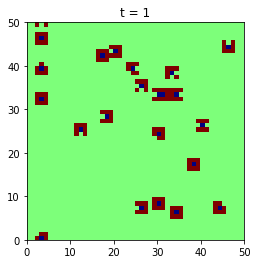

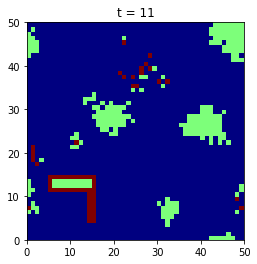

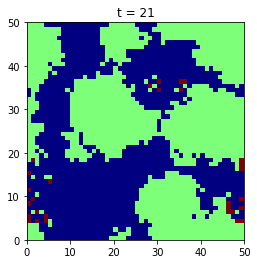

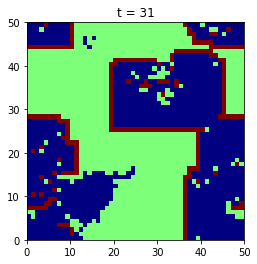

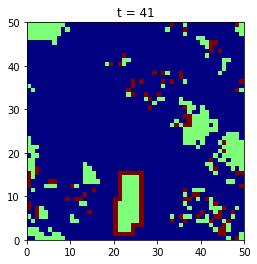

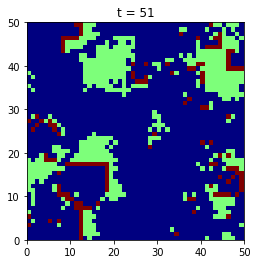

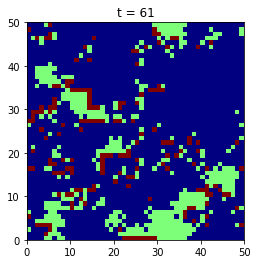

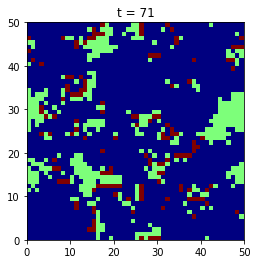

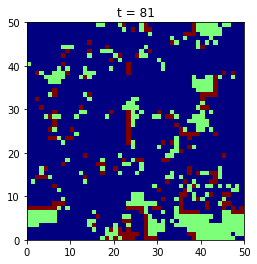

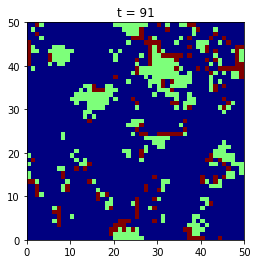

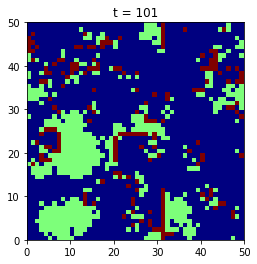

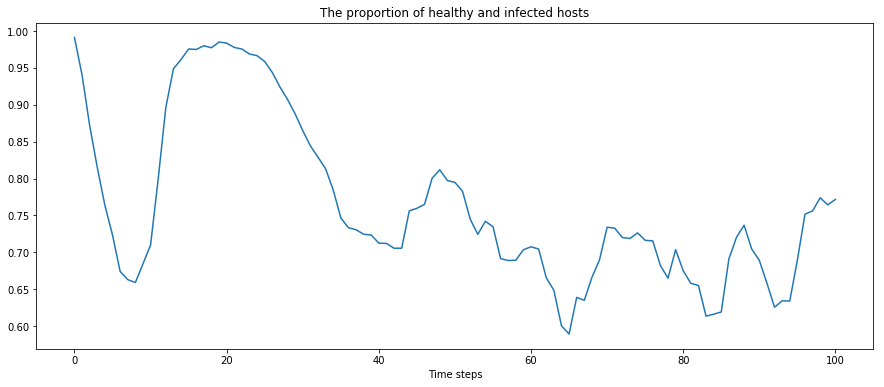

In [69]:
init()
for i in range(0, 101):
    step()
    if i%10 == 0:
        draw()
plot_proportion()

# Sayama Exercise 12.6
Confirm that the probabilities listed in the last column of Table 12.1 are a valid probability distribution, i.e., that the sum of them is 1.

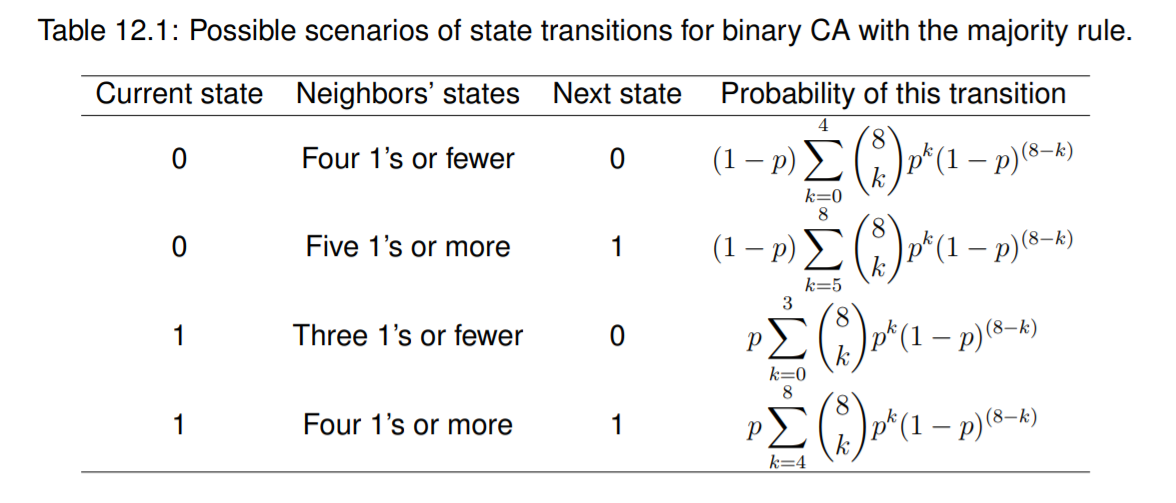

In [47]:
from PIL import Image
Image.open("Host pathogen.png")

The probability mass function of a binomial distribution
$$\left(\begin{array}{ccc}n\\k\end{array}\right)\cdot p^k\left(1-p\right)^{n-k}$$

The four expressions are conditional probabilities dependent on the initial state (either 1 or 0).
- $P\left(0\mid0\right)=(1-p)\sum_{k=0}^4{8\choose k}p^k(1-p)^{8-k}$
- $P\left(1\mid0\right)=(1-p)\sum_{k=5}^8{8\choose k}p^k(1-p)^{8-k}$ 
- $P\left(0\mid1\right)=p\sum_{k=0}^3{8\choose k}p^k(1-p)^{8-k}$
- $P\left(1\mid1\right)=p\sum_{k=4}^8{8\choose k}p^k(1-p)^{8-k}$

The sum of the four expressions yields:
$$(1-p)\sum_{k=0}^8{8\choose k}p^k(1-p)^{8-k} + p\sum_{k=0}^8{8\choose k}p^k(1-p)^{8-k}$$
Simplifying and taking the sums as a common factor:
$$[(1-p)+(p)]\sum_{k=0}^8{8\choose k}p^k(1-p)^{8-k}$$
$$\sum_{k=0}^8{8\choose k}p^k(1-p)^{8-k}$$

Which is the same form of the PMF of a binomial distribution:
$$\sum_{k=0}^8{8\choose k}p^k(1-p)^{8-k} = [(1-p)+(p)]^8 = (1)^8 = 1$$

# Sayama Exercise 12.7
Apply mean-field approximation to the Game of Life 2-D CA model. Derive a difference equation for the average state density pt, and predict its asymptotic behavior. Then compare the result with the actual density obtained from a simulation result. Do they match or not? Why?

In [106]:
n = 100
p = 0.2

def initialize():
    global config, nextconfig, density
    density = []
    config = PL.zeros([n, n])
    for x in range(n):
        for y in range(n):
            config[x, y] = 1 if PL.random() < p else 0
            nextconfig = PL.zeros([n, n])
            
def observe():
    global config, nextconfig
    PL.cla()
    PL.imshow(config, vmin = 0, vmax = 1, cmap = PL.cm.binary)
    PL.show()
    PL.figure(figsize=(15, 6))
    PL.plot(density)
    plt.axhline(0.1088)
    PL.title("Density")
    PL.xlabel("Time steps")
    PL.show()

def update():
    global config, nextconfig, density
    for x in range(n):
        for y in range(n):
            count = 0
            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    count += config[(x + dx) % n, (y + dy) % n]
            """
            Any live cell with fewer than two live neighbours dies, as if by underpopulation.
            Any live cell with two or three live neighbours lives on to the next generation.
            Any live cell with more than three live neighbours dies, as if by overpopulation.
            Any dead cell with exactly three live neighbours becomes a live cell, as if by reproduction.
            """
            if config[x, y] == 0:
                nextconfig[x, y] = 1 if count == 3 else 0
            if config[x, y] == 1:
                nextconfig[x, y] = 1 if (count == 4) or (count == 3) else 0
    
    density.append(np.mean(config.ravel()))
    config, nextconfig = nextconfig, config

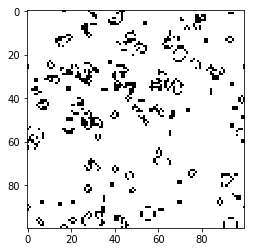

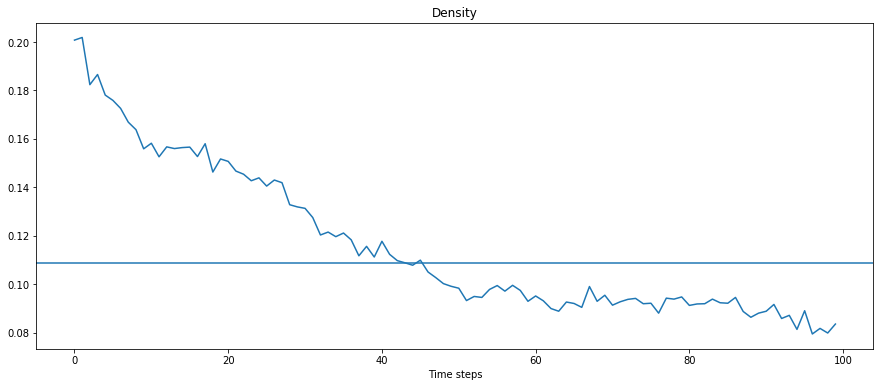

In [107]:
initialize()
for i in range(100):
    update()
observe()

# Turing Pattern Formation

In [76]:
# Simple CA simulator in Python
#
# *** Turing Pattern Formation ***
#
# Copyright 2008-2012 Hiroki Sayama
# sayama@binghamton.edu

# Modified to run with Python 3

import matplotlib
#matplotlib.use('TkAgg')

import pylab as PL
import random as RD
import scipy as SP

RD.seed()

width = 50
height = 50
initProb = 0.5
Ra = 1
Ri = 5
Wa = 1
Wi = 0.1

def init():
    global time, config, nextConfig, density
    density = []
    time = 0
    
    config = SP.zeros([height, width])
    for x in range(width):
        for y in range(height):
            if RD.random() < initProb:
                state = 1
            else:
                state = 0
            config[y, x] = state

    nextConfig = SP.zeros([height, width])

def draw():
    PL.cla()
    PL.pcolor(config, vmin = 0, vmax = 1, cmap = PL.cm.binary)
    PL.axis('image')
    PL.title('t = ' + str(time))
    PL.show()
    
def plot_density():
    PL.plot(density)
    PL.title("The proportion of healthy and infected hosts")
    PL.xlabel("Time steps")
    PL.show()

def step():
    global time, config, nextConfig, density

    time += 1

    for x in range(width):
        for y in range(height):
            state = config[y, x]
            na = ni = 0
            for dx in range(- Ra, Ra + 1):
                for dy in range(- Ra, Ra + 1):
                    na += config[(y+dy)%height, (x+dx)%width]
            for dx in range(- Ri, Ri + 1):
                for dy in range(- Ri, Ri + 1):
                    ni += config[(y+dy)%height, (x+dx)%width]
            if na * Wa - ni * Wi > 0:
                state = 1
            else:
                state = 0
            nextConfig[y, x] = state
    density.append(np.mean(config.ravel()))
    config, nextConfig = nextConfig, config

#import pycxsimulator
#pycxsimulator.GUI().start(func=[init,draw,step])

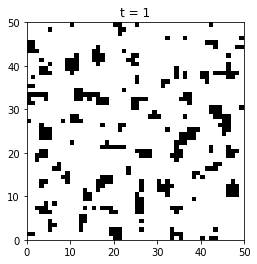

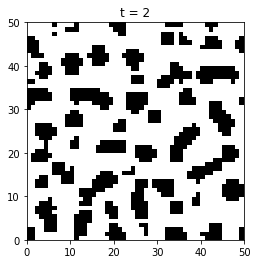

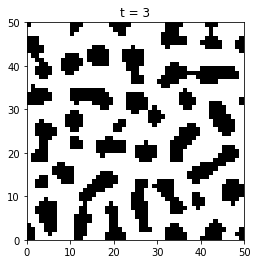

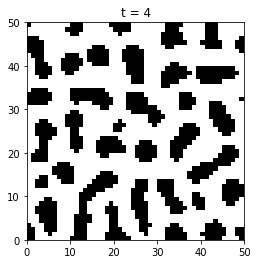

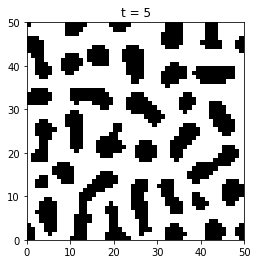

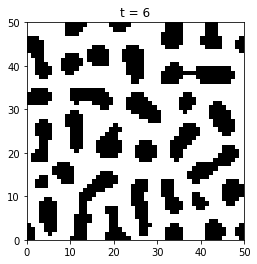

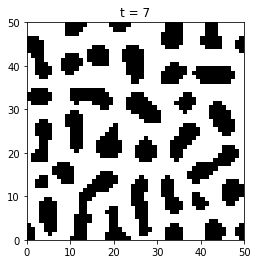

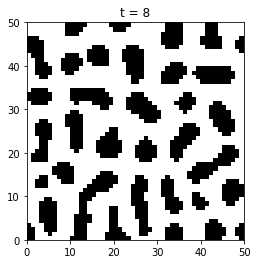

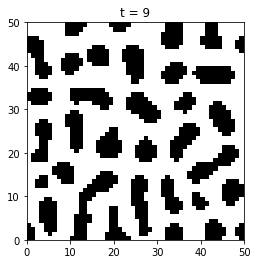

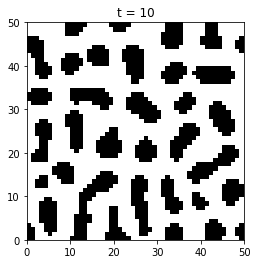

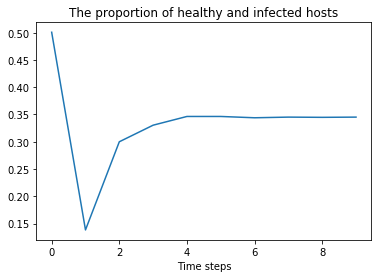

In [77]:
init()
for i in range(10):
    step()
    draw()
plot_density()

# Waves in excitable media

In [78]:
# Simple CA simulator in Python
#
# *** Waves in excitable media ***
#
# Copyright 2008-2012 Hiroki Sayama
# sayama@binghamton.edu

# Modified to run with Python 3

import matplotlib
#matplotlib.use('TkAgg')

import pylab as PL
import random as RD
import scipy as SP

RD.seed()

width = 50
height = 50
initProb = 0.1
maxState = 6

def init():
    global time, config, nextConfig, density
    density = []
    time = 0

    config = SP.zeros([height, width])
    for x in range(width):
        for y in range(height):
            if RD.random() < initProb:
                state = maxState
            else:
                state = 0
            config[y, x] = state

    nextConfig = SP.zeros([height, width])

def draw():
    PL.cla()
    PL.pcolor(config, vmin = 0, vmax = maxState, cmap = PL.cm.binary)
    PL.axis('image')
    PL.title('t = ' + str(time))
    PL.show()
    
def plot_density():
    PL.plot(density)
    PL.title("The proportion of healthy and infected hosts")
    PL.xlabel("Time steps")
    PL.show()
    
def step():
    global time, config, nextConfig, density

    time += 1

    for x in range(width):
        for y in range(height):
            state = config[y, x]
            if state == 0:
                num = 0
                for dx in range(-1, 2):
                    for dy in range(-1, 2):
                        if config[(y+dy)%height, (x+dx)%width] == maxState:
                            num += 1
                if RD.random() * 3 < num:
                    state = maxState
                else:
                    state = 0
            else:
                state -= 1
            nextConfig[y, x] = state
    density.append(np.mean(config.ravel()))
    config, nextConfig = nextConfig, config

#import pycxsimulator
#pycxsimulator.GUI().start(func=[init,draw,step])

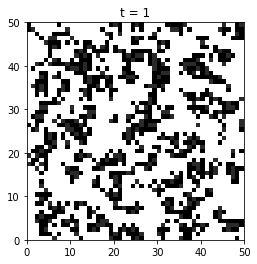

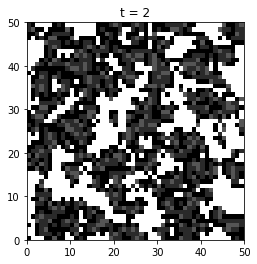

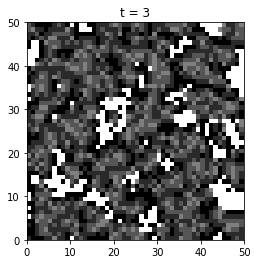

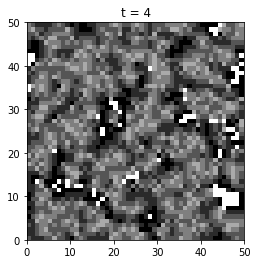

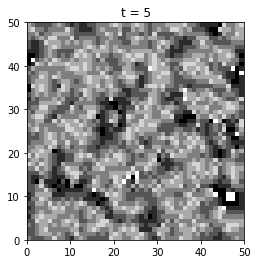

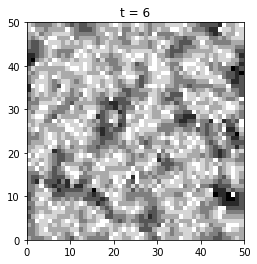

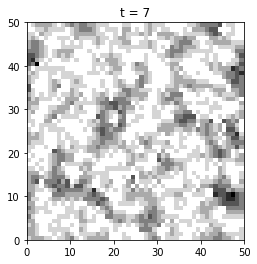

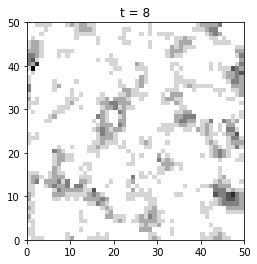

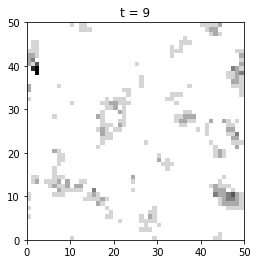

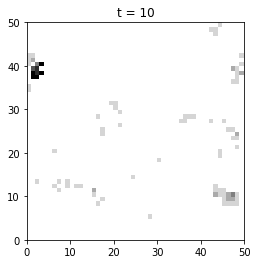

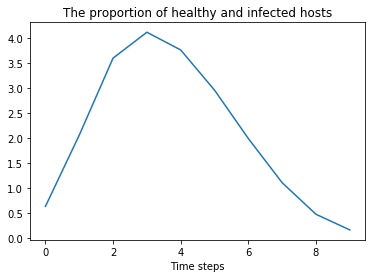

In [79]:
init()
for i in range(10):
    step()
    draw()
plot_density()